In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from sharpening_functions import *

In [3]:
max_039 = []
min_039 = []
for name in os.listdir("Landsat Subsets/039"):
    img = np.load("Landsat Subsets/039/" + name)
    max_039.append(np.max(img))
    min_039.append(np.min(img))
    
max_103 = []
min_103 = []
for name in os.listdir("Landsat Subsets/103"):
    img = np.load("Landsat Subsets/103/" + name)
    max_103.append(np.max(img))
    min_103.append(np.min(img))

In [4]:
print('max 039 ' + str(max(max_039)))
print('max 103 ' + str(max(max_103)))
print('min 039 ' + str(min(min_039)))
print('min 103 ' + str(min(min_103)))

max 039 382.9795
max 103 309.1703
min 039 294.7677
min 103 290.02103


In [5]:
data_original = dict()
data_esrgan = dict()

for wavelength in '039', '103':
    data_original[wavelength] = []
    data_esrgan[wavelength] = []
    for name in os.listdir("Landsat Subsets/" + wavelength):
            img = np.load("Landsat Subsets/" + wavelength + '/' + name)
            data_original[wavelength].append(img)
            data_esrgan[wavelength].append(esrgan_sharpening_img(img))

In [6]:
data_esrgan['039'][0];

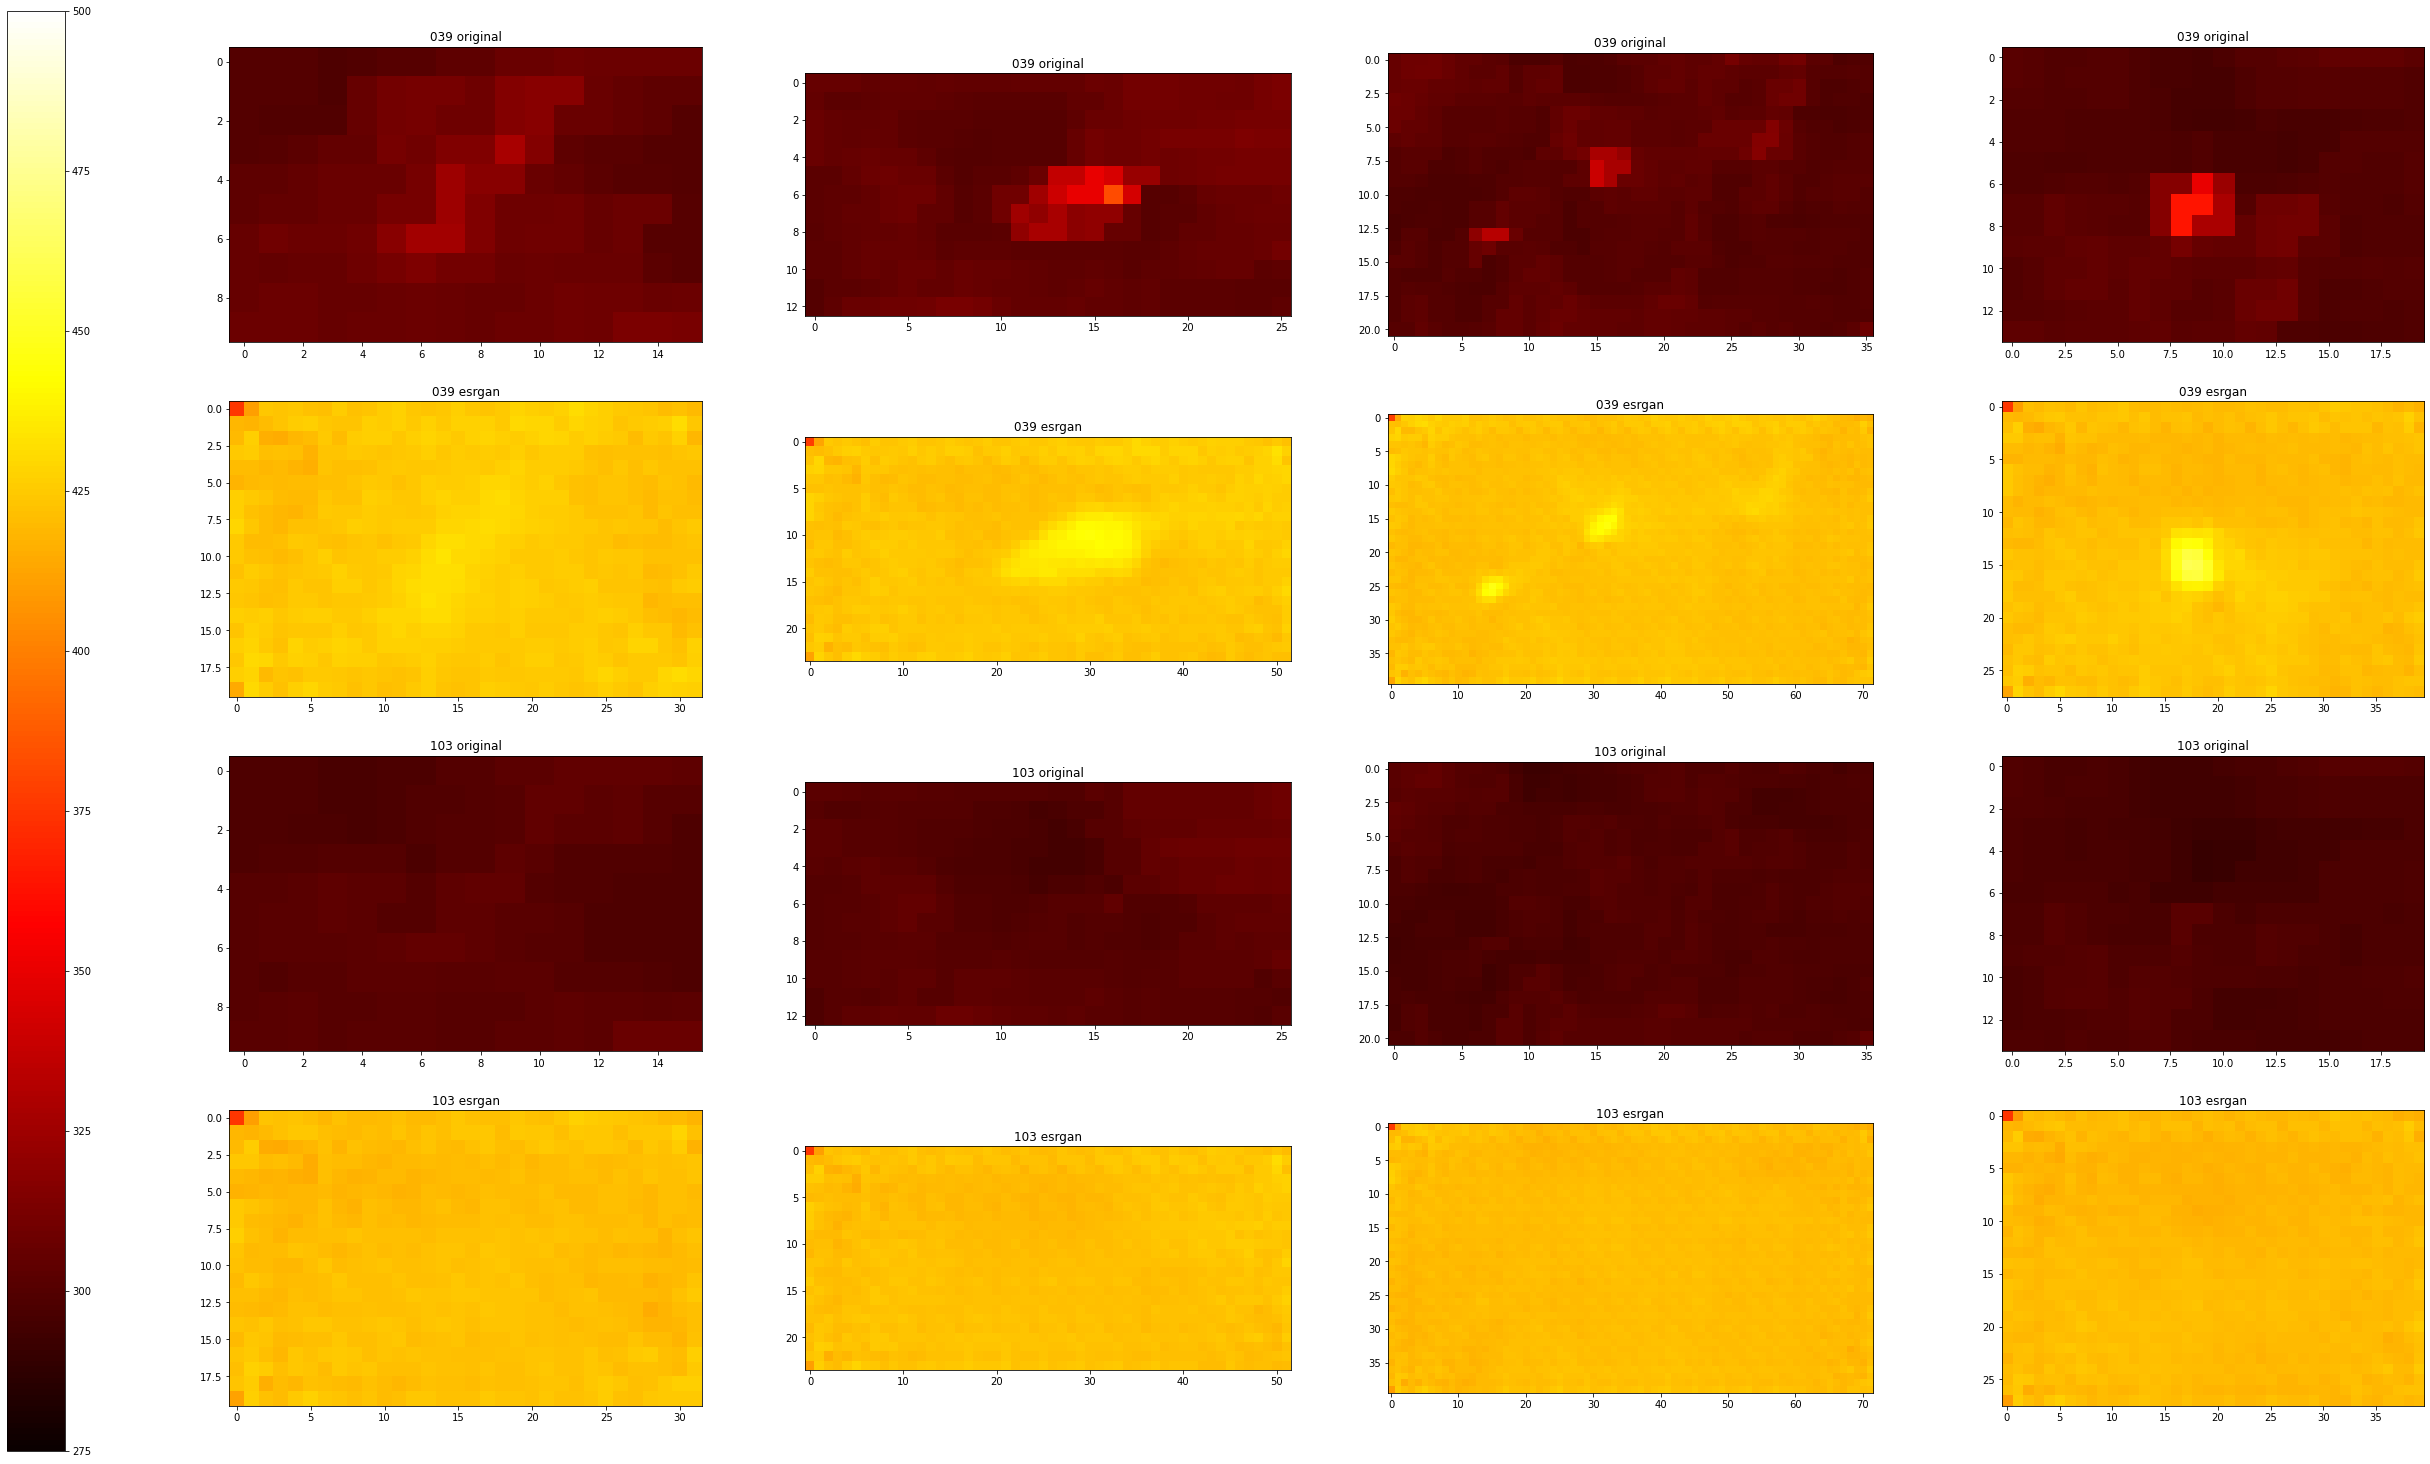

In [8]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 4, figsize=(40, 25))
max_temp = 500
min_temp = 275

for n in range(4):
    wavelength = '039'
    im = ax1[n].imshow(data_original[wavelength][n], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax1[n].set_title(wavelength + ' original')

    ax2[n].imshow(data_esrgan[wavelength][n], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax2[n].set_title(wavelength + ' esrgan')

    wavelength = '103'
    ax3[n].imshow(data_original[wavelength][n], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax3[n].set_title(wavelength + ' original')

    ax4[n].imshow(data_esrgan[wavelength][n], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax4[n].set_title(wavelength + ' esrgan')
    
cb_ax = f.add_axes([0.05, 0.1, 0.02, 0.8])
cbar = f.colorbar(im, cax=cb_ax)